Primary goal is to define a function by which we give it a file name and mass threshold and the entirety of the calculation in terms of CFs, MCFs, and various cuts are output as a single data vector. We will start by assuming a value of fname and mthresh and go from there, and see what needs changing.

In [14]:
# required imports for the function here
%matplotlib inline

import numpy as np
from numpy.lib.recfunctions import append_fields
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import halotools.mock_observables as mo
import halotools.sim_manager as sm


In [43]:
fname = './l0500_d340b.catalog' # file name to z0.0.catalog
mthresh = 3e12  # threshold mass in Msun/h
gnewton = 4.302e-6
lbox = 500.0
vhost_min = 240.0
vrat_frac = 0.3
vsub_min = vhost_min * vrat_frac
nrand = 10

# define dict pointing to all marks of interest
rs_dict = {'halo_id':(0,'i8'), 'halo_mass':(2,'f8'), 'halo_vmax':(3,'f8'), 'halo_rvir':(5,'f8'),
           'halo_rs':(6,'f8'), 'halo_x':(8,'f8'), 'halo_y':(9,'f8'), 'halo_z':(10,'f8'),
           'halo_spin':(17,'f8'), 'halo_ctoa':(28, 'f8'), 'halo_pid':(33,'i8')}

reader = sm.TabularAsciiReader(fname, rs_dict, row_cut_min_dict={'halo_mass':mthresh},
                               row_cut_eq_dict={'halo_pid':-1})
hosts_data = reader.read_ascii()

reader = sm.TabularAsciiReader(fname, rs_dict, row_cut_min_dict={'halo_vmax':vsub_min}, row_cut_neq_dict={'halo_pid':-1})
subs_data = reader.read_ascii()

# add calculated marks
vratio_temp = hosts_data['halo_vmax']/(np.sqrt(gnewton * hosts_data['halo_mass']/hosts_data['halo_rvir']))
cnfw_temp = hosts_data['halo_rvir']/hosts_data['halo_rs']

# now we want to go host halo by host halo, match pid to subhalos, and
# count the number that meet our requirements and then add this on
# as both a number and a flag.
nflagtemp = np.zeros(len(hosts_data))
subcount = np.zeros(len(hosts_data))

for i in range(0, len(hosts_data)):
   if hosts_data[i]['halo_vmax'] > vhost_min:
      nflagtemp[i] = 1
      subs_cut = subs_data[np.where(subs_data['halo_pid'] == hosts_data[i]['halo_id'])]
      for j in range(0, len(subs_cut)):
         xdist = subs_cut[j]['halo_x'] - hosts_data[i]['halo_x']
         ydist = subs_cut[j]['halo_y'] - hosts_data[i]['halo_y']
         zdist = subs_cut[j]['halo_z'] - hosts_data[i]['halo_z']
         totdist = (xdist**2 + ydist**2 + zdist**2)*0.001
         if totdist < hosts_data[i]['halo_rvir']:
            ratio = subs_cut[j]['halo_vmax']/hosts_data[i]['halo_vmax']
            if ratio > vrat_frac:
               subcount[i] = subcount[i] + 1

hosts_data_alt =  append_fields(hosts_data, ('halo_cV', 'halo_cNFW', 'halo_satflag', 'halo_nsat'), (vratio_temp, cnfw_temp, nflagtemp, subcount))

# now that we have data, we need to mass correct all of our marks
mass_sort = np.sort(hosts_data_alt, order='halo_mass')

vratio_binned = stats.binned_statistic(np.log10(mass_sort['halo_mass']),
                                       (mass_sort['halo_cV']),
                                       statistic='mean', bins=10)
vratio_fix = (mass_sort['halo_cV']) / vratio_binned.statistic[vratio_binned.binnumber-1]
mass_sort['halo_cV'] = vratio_fix

cnfw_binned = stats.binned_statistic(np.log10(mass_sort['halo_mass']),
                                     (mass_sort['halo_cNFW']),
                                     statistic = 'mean', bins=10)
cnfw_fix = (mass_sort['halo_cNFW']) / cnfw_binned.statistic[cnfw_binned.binnumber-1]
mass_sort['halo_cNFW'] = cnfw_fix

shape_binned = stats.binned_statistic(np.log10(mass_sort['halo_mass']),
                                      (mass_sort['halo_ctoa']),
                                      statistic='mean', bins=10)
shape_fix = (mass_sort['halo_ctoa']) / shape_binned.statistic[shape_binned.binnumber-1]
mass_sort['halo_ctoa'] = shape_fix

spin_binned = stats.binned_statistic(np.log10(mass_sort['halo_mass']),
                                     (mass_sort['halo_spin']),
                                     statistic='mean', bins=10)
spin_fix = (mass_sort['halo_spin']) / spin_binned.statistic[spin_binned.binnumber-1]
mass_sort['halo_spin'] = spin_fix

# now all our marks have been fixed. First let's run through the marked correlation functions
# then we can take various correlation function comparisons

pos = np.vstack((mass_sort['halo_x'], mass_sort['halo_y'], mass_sort['halo_z'])).T

minlog = np.log10(2.0)
maxlog = np.log10(20.0)
nstep = 10
steplog = (maxlog - minlog) / (nstep - 1.)
logbins = np.arange(minlog, maxlog+steplog, steplog)
binmids = np.zeros(30)
for i in range(0,nstep):
    binmids[i] = (logbins[i]+logbins[i+1])/2.

xi = mo.tpcf(pos, 10**logbins, period=lbox)

mcf_vratio = mo.marked_tpcf(pos, 10**logbins, marks1=mass_sort['halo_cV'], period=lbox,
                            normalize_by='number_counts', wfunc=1)
mcfn_vratio = (mcf_vratio - np.mean(mass_sort['halo_cV'])**2)/(np.var(mass_sort['halo_cV']))

mcf_cnfw = mo.marked_tpcf(pos, 10**logbins, marks1=mass_sort['halo_cNFW'], period=lbox,
                          normalize_by='number_counts', wfunc=1)
mcfn_cnfw = (mcf_cnfw - np.mean(mass_sort['halo_cNFW'])**2)/(np.var(mass_sort['halo_cNFW']))

mcf_ctoa = mo.marked_tpcf(pos, 10**logbins, marks1=mass_sort['halo_ctoa'], period=lbox,
                          normalize_by='number_counts', wfunc=1)
mcfn_ctoa = (mcf_ctoa - np.mean(mass_sort['halo_ctoa'])**2)/(np.var(mass_sort['halo_ctoa']))

mcf_spin = mo.marked_tpcf(pos, 10**logbins, marks1=mass_sort['halo_spin'], period=lbox,
                          normalize_by='number_counts', wfunc=1)
mcfn_spin = (mcf_spin - np.mean(mass_sort['halo_spin'])**2)/(np.var(mass_sort['halo_spin']))

mass_sort_satflag = mass_sort[np.where(mass_sort['halo_satflag']==1)]
mcf_nsat = mo.marked_tpcf(pos[np.where(mass_sort['halo_satflag']==1)], 10**logbins, marks1=mass_sort_satflag['halo_nsat'], period=lbox, normalize_by='number_counts', wfunc=1)

mcfn_nsat = (mcf_nsat - np.mean(mass_sort_satflag['halo_nsat'])**2)/(np.var(mass_sort_satflag['halo_nsat']))

# how we'll need to shuffle the marks N times, run the calculation N times,
# and determine the min and max range of the mark calculation. So:
mcf_vratio_rand = np.zeros((nstep, nrand))
mcfn_vratio_rand = np.zeros((nstep, nrand))
mcf_cnfw_rand = np.zeros((nstep, nrand))
mcfn_cnfw_rand = np.zeros((nstep, nrand))
mcf_ctoa_rand = np.zeros((nstep, nrand))
mcfn_ctoa_rand = np.zeros((nstep, nrand))
mcf_spin_rand = np.zeros((nstep, nrand))
mcfn_spin_rand = np.zeros((nstep, nrand))
mcf_nsat_rand = np.zeros((nstep, nrand))
mcfn_nsat_rand = np.zeros((nstep, nrand))

for i in range(0, nrand):
    randm_vratio = np.random.permutation(mass_sort['halo_cV'])
    randm_cnfw = np.random.permutation(mass_sort['halo_cNFW'])
    randm_ctoa = np.random.permutation(mass_sort['halo_ctoa'])
    randm_spin = np.random.permutation(mass_sort['halo_spin'])
    randm_nsat = np.random.permutation(mass_sort_satflag['halo_nsat'])

    mcf_vratio_rand[:,i] = mo.marked_tpcf(pos, 10**logbins, marks1=randm_vratio, period=lbox,
                                      normalize_by='number_counts', wfunc=1)
    mcfn_vratio_rand[:,i] = (mcf_vratio_rand[:,i] - np.mean(randm_vratio)**2)/(np.var(randm_vratio))
    mcf_cnfw_rand[:,i] = mo.marked_tpcf(pos, 10**logbins, marks1=randm_cnfw, period=lbox,
                                        normalize_by='number_counts', wfunc=1)
    mcfn_cnfw_rand[:,i] = (mcf_cnfw_rand[:,i] - np.mean(randm_cnfw)**2)/(np.var(randm_cnfw))
    mcf_ctoa_rand[:,i] = mo.marked_tpcf(pos, 10**logbins, marks1=randm_ctoa, period=lbox,
                                        normalize_by='number_counts', wfunc=1)
    mcfn_ctoa_rand[:,i] = (mcf_ctoa_rand[:,i] - np.mean(randm_ctoa)**2)/(np.var(randm_ctoa))
    mcf_spin_rand[:,i] = mo.marked_tpcf(pos, 10**logbins, marks1=randm_spin, period=lbox,
                                        normalize_by='number_counts', wfunc=1)
    mcfn_spin_rand[:,i] = (mcf_spin_rand[:,i] - np.mean(randm_spin)**2)/(np.var(randm_spin))
    mcf_nsat_rand[:,i] = mo.marked_tpcf(pos[np.where(mass_sort['halo_satflag']==1)], 10**logbins, marks1=randm_nsat, period=lbox, normalize_by='number_counts', wfunc=1)
    mcfn_nsat_rand[:,i] = (mcf_nsat_rand[:,i] - np.mean(randm_nsat)**2)/(np.var(randm_nsat))

mcfn_vratio_min = np.zeros(nstep)
mcfn_vratio_max = np.zeros(nstep)
mcfn_cnfw_min = np.zeros(nstep)
mcfn_cnfw_max = np.zeros(nstep)
mcfn_ctoa_min = np.zeros(nstep)
mcfn_ctoa_max = np.zeros(nstep)
mcfn_spin_min = np.zeros(nstep)
mcfn_spin_max = np.zeros(nstep)
mcfn_nsat_min = np.zeros(nstep)
mcfn_nsat_max = np.zeros(nstep)

for i in range(0, nstep):
    mcfn_vratio_min[i] = np.percentile(mcfn_vratio_rand[i,:],2, interpolation='nearest')
    mcfn_vratio_max[i] = np.percentile(mcfn_vratio_rand[i,:],98,interpolation='nearest')
    mcfn_cnfw_min[i] = np.percentile(mcfn_cnfw_rand[i,:],2, interpolation='nearest')
    mcfn_cnfw_max[i] = np.percentile(mcfn_cnfw_rand[i,:],98, interpolation='nearest')
    mcfn_ctoa_min[i] = np.percentile(mcfn_ctoa_rand[i,:],2, interpolation='nearest')
    mcfn_ctoa_max[i] = np.percentile(mcfn_ctoa_rand[i,:],98, interpolation='nearest')
    mcfn_spin_min[i] = np.percentile(mcfn_spin_rand[i,:],2, interpolation='nearest')
    mcfn_spin_max[i] = np.percentile(mcfn_spin_rand[i,:],98, interpolation='nearest')
    mcfn_nsat_min[i] = np.percentile(mcfn_nsat_rand[i,:],2, interpolation='nearest')
    mcfn_nsat_max[i] = np.percentile(mcfn_nsat_rand[i,:],98, interpolation='nearest')
    
print 'Complete'


...Processing ASCII data of file: 
/data/asv13/projects/haloenviron-pipeline/l0500_d340b.catalog
 
Total number of rows in detected data = 2032025
Number of rows in detected header = 15 

... working on chunk 0 of 1
Total runtime to read in ASCII = 13.62 seconds



...Processing ASCII data of file: 
/data/asv13/projects/haloenviron-pipeline/l0500_d340b.catalog
 
Total number of rows in detected data = 2032025
Number of rows in detected header = 15 

... working on chunk 0 of 1
Total runtime to read in ASCII = 13.49 seconds


Complete


In [59]:
cnfw_sort = np.sort(mass_sort, order='halo_spin')
print len(cnfw_sort)

lowlim=int(np.floor(.2*len(cnfw_sort)))
highlim=int(np.floor(.8*len(cnfw_sort)))
low_cnfw_sort = cnfw_sort[0:lowlim]
high_cnfw_sort = cnfw_sort[highlim:-1]
lowpos = np.vstack((low_cnfw_sort['halo_x'], low_cnfw_sort['halo_y'], low_cnfw_sort['halo_z'])).T
highpos = np.vstack((high_cnfw_sort['halo_x'], high_cnfw_sort['halo_y'], high_cnfw_sort['halo_z'])).T
x_rand = lbox * np.random.random(len(lowpos)*3)
y_rand = lbox * np.random.random(len(lowpos)*3)
z_rand = lbox * np.random.random(len(lowpos)*3)
randpos = np.vstack((x_rand,y_rand,z_rand)).T
Nsub = np.array([2,2,2])
xi_low, cov_low = mo.tpcf_jackknife(lowpos, randoms=randpos, rbins=10**logbins, Nsub=Nsub, period=lbox)
xi_high, cov_high = mo.tpcf_jackknife(highpos, randoms=randpos, rbins=10**logbins, Nsub=Nsub, period=lbox)
error_low = np.sqrt(1./np.diag(cov_low))
error_high = np.sqrt(1./np.diag(cov_high))
yerr_low_low = np.maximum(1e-2, xi_low - error_low)
yerr_high_low = xi_low + error_low
yerr_low_high = np.maximum(1e-2, xi_high - error_high)
yerr_high_high = xi_high + error_high

xi_comp_20p = (xi_high - xi_low) / xi

99944


In [60]:
lowlim=int(np.floor(.5*len(cnfw_sort)))
highlim=int(np.floor(.5*len(cnfw_sort)))
low_cnfw_sort = cnfw_sort[0:lowlim]
high_cnfw_sort = cnfw_sort[highlim:-1]
lowpos = np.vstack((low_cnfw_sort['halo_x'], low_cnfw_sort['halo_y'], low_cnfw_sort['halo_z'])).T
highpos = np.vstack((high_cnfw_sort['halo_x'], high_cnfw_sort['halo_y'], high_cnfw_sort['halo_z'])).T
x_rand = lbox * np.random.random(len(lowpos)*3)
y_rand = lbox * np.random.random(len(lowpos)*3)
z_rand = lbox * np.random.random(len(lowpos)*3)
randpos = np.vstack((x_rand,y_rand,z_rand)).T
Nsub = np.array([2,2,2])
xi_low, cov_low = mo.tpcf_jackknife(lowpos, randoms=randpos, rbins=10**logbins, Nsub=Nsub, period=lbox)
xi_high, cov_high = mo.tpcf_jackknife(highpos, randoms=randpos, rbins=10**logbins, Nsub=Nsub, period=lbox)
error_low = np.sqrt(1./np.diag(cov_low))
error_high = np.sqrt(1./np.diag(cov_high))
yerr_low_low = np.maximum(1e-2, xi_low - error_low)
yerr_high_low = xi_low + error_low
yerr_low_high = np.maximum(1e-2, xi_high - error_high)
yerr_high_high = xi_high + error_high

xi_comp_50p = (xi_high - xi_low) / xi

In [61]:
lowlim=int(np.floor(.02*len(cnfw_sort)))
highlim=int(np.floor(.98*len(cnfw_sort)))
low_cnfw_sort = cnfw_sort[0:lowlim]
high_cnfw_sort = cnfw_sort[highlim:-1]
lowpos = np.vstack((low_cnfw_sort['halo_x'], low_cnfw_sort['halo_y'], low_cnfw_sort['halo_z'])).T
highpos = np.vstack((high_cnfw_sort['halo_x'], high_cnfw_sort['halo_y'], high_cnfw_sort['halo_z'])).T
x_rand = lbox * np.random.random(len(lowpos)*3)
y_rand = lbox * np.random.random(len(lowpos)*3)
z_rand = lbox * np.random.random(len(lowpos)*3)
randpos = np.vstack((x_rand,y_rand,z_rand)).T
Nsub = np.array([2,2,2])
xi_low, cov_low = mo.tpcf_jackknife(lowpos, randoms=randpos, rbins=10**logbins, Nsub=Nsub, period=lbox)
xi_high, cov_high = mo.tpcf_jackknife(highpos, randoms=randpos, rbins=10**logbins, Nsub=Nsub, period=lbox)
error_low = np.sqrt(1./np.diag(cov_low))
error_high = np.sqrt(1./np.diag(cov_high))
yerr_low_low = np.maximum(1e-2, xi_low - error_low)
yerr_high_low = xi_low + error_low
yerr_low_high = np.maximum(1e-2, xi_high - error_high)
yerr_high_high = xi_high + error_high

xi_comp_2p = (xi_high - xi_low) / xi

In [62]:
lowlim=int(np.floor(.10*len(cnfw_sort)))
highlim=int(np.floor(.90*len(cnfw_sort)))
low_cnfw_sort = cnfw_sort[0:lowlim]
high_cnfw_sort = cnfw_sort[highlim:-1]
lowpos = np.vstack((low_cnfw_sort['halo_x'], low_cnfw_sort['halo_y'], low_cnfw_sort['halo_z'])).T
highpos = np.vstack((high_cnfw_sort['halo_x'], high_cnfw_sort['halo_y'], high_cnfw_sort['halo_z'])).T
x_rand = lbox * np.random.random(len(lowpos)*3)
y_rand = lbox * np.random.random(len(lowpos)*3)
z_rand = lbox * np.random.random(len(lowpos)*3)
randpos = np.vstack((x_rand,y_rand,z_rand)).T
Nsub = np.array([2,2,2])
xi_low, cov_low = mo.tpcf_jackknife(lowpos, randoms=randpos, rbins=10**logbins, Nsub=Nsub, period=lbox)
xi_high, cov_high = mo.tpcf_jackknife(highpos, randoms=randpos, rbins=10**logbins, Nsub=Nsub, period=lbox)
error_low = np.sqrt(1./np.diag(cov_low))
error_high = np.sqrt(1./np.diag(cov_high))
yerr_low_low = np.maximum(1e-2, xi_low - error_low)
yerr_high_low = xi_low + error_low
yerr_low_high = np.maximum(1e-2, xi_high - error_high)
yerr_high_high = xi_high + error_high

xi_comp_10p = (xi_high - xi_low) / xi

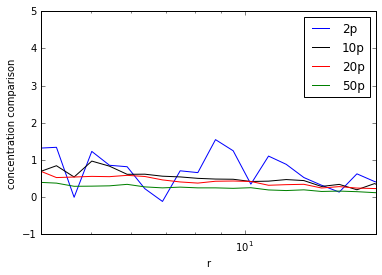

In [63]:
plt.semilogx(10**binmids, xi_comp_2p, 'b-', label='2p')
plt.semilogx(10**binmids, xi_comp_10p, 'k-', label='10p')
plt.semilogx(10**binmids, xi_comp_20p, 'r-', label='20p')
plt.semilogx(10**binmids, xi_comp_50p, 'g-', label='50p')
plt.xlim(4,18)
plt.ylim(-1,5)
plt.xlabel('r')
plt.ylabel('concentration comparison')
plt.legend(loc='upper right')

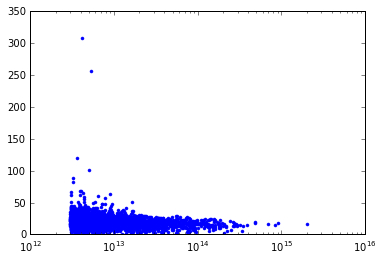

In [8]:
plt.semilogx(hosts_data_alt['halo_mass'], hosts_data_alt['halo_cNFW'], 'b.')

(0.8, 1.2)

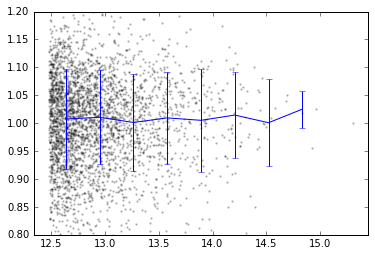

In [45]:
total_bins = 10

X = np.log10(mass_sort['halo_mass'])
Y = mass_sort['halo_cV']

bins = np.linspace(X.min(),X.max(), total_bins)
delta = bins[1]-bins[0]
idx  = np.digitize(X,bins)
running_median = [np.median(Y[idx==k]) for k in range(total_bins)]

plt.scatter(X,Y,color='k',alpha=.2,s=2)
running_std    = [Y[idx==k].std() for k in range(total_bins)]
plt.errorbar(bins-delta/2,running_median,
              running_std)
plt.axis('tight')
plt.ylim(0.8,1.2)

(0.8, 1.2)

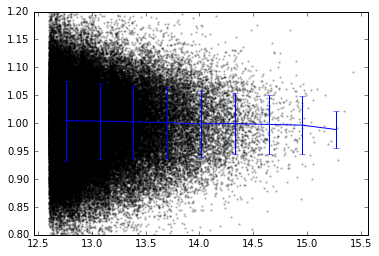

In [42]:
total_bins = 10

X = np.log10(mass_sort['halo_mass'])
Y = mass_sort['halo_cV']

bins = np.linspace(X.min(),X.max(), total_bins)
delta = bins[1]-bins[0]
idx  = np.digitize(X,bins)
running_median = [np.median(Y[idx==k]) for k in range(total_bins)]

plt.scatter(X,Y,color='k',alpha=.2,s=2)
running_std    = [Y[idx==k].std() for k in range(total_bins)]
plt.errorbar(bins-delta/2,running_median,
              running_std)
plt.axis('tight')
plt.ylim(0.8,1.2)

In [11]:
fname = './l0500_d200b.catalog' # file name to z0.0.catalog
mthresh = 1e10  # threshold mass in Msun/h
gnewton = 4.302e-6
lbox = 500.0
vhost_min = 240.0
vrat_frac = 0.3
vsub_min = vhost_min * vrat_frac
nrand = 10

# define dict pointing to all marks of interest
rs_dict = {'halo_id':(0,'i8'), 'halo_mass':(2,'f8'), 'halo_vmax':(3,'f8'), 'halo_rvir':(5,'f8'),
           'halo_rs':(6,'f8'), 'halo_x':(8,'f8'), 'halo_y':(9,'f8'), 'halo_z':(10,'f8'),
           'halo_spin':(17,'f8'), 'halo_ctoa':(28, 'f8'), 'halo_pid':(33,'i8')}

reader = sm.TabularAsciiReader(fname, rs_dict, row_cut_min_dict={'halo_mass':mthresh},
                               row_cut_eq_dict={'halo_pid':-1})
hosts_data = reader.read_ascii()

reader = sm.TabularAsciiReader(fname, rs_dict, row_cut_min_dict={'halo_vmax':vsub_min}, row_cut_neq_dict={'halo_pid':-1})
subs_data = reader.read_ascii()

# add calculated marks
vratio_temp = hosts_data['halo_vmax']/(np.sqrt(gnewton * hosts_data['halo_mass']/hosts_data['halo_rvir']))
cnfw_temp = hosts_data['halo_rvir']/hosts_data['halo_rs']

# now we want to go host halo by host halo, match pid to subhalos, and
# count the number that meet our requirements and then add this on
# as both a number and a flag.
nflagtemp = np.zeros(len(hosts_data))
subcount = np.zeros(len(hosts_data))

for i in range(0, len(hosts_data)):
   if hosts_data[i]['halo_vmax'] > vhost_min:
      nflagtemp[i] = 1
      subs_cut = subs_data[np.where(subs_data['halo_pid'] == hosts_data[i]['halo_id'])]
      for j in range(0, len(subs_cut)):
         xdist = subs_cut[j]['halo_x'] - hosts_data[i]['halo_x']
         ydist = subs_cut[j]['halo_y'] - hosts_data[i]['halo_y']
         zdist = subs_cut[j]['halo_z'] - hosts_data[i]['halo_z']
         totdist = (xdist**2 + ydist**2 + zdist**2)*0.001
         if totdist < hosts_data[i]['halo_rvir']:
            ratio = subs_cut[j]['halo_vmax']/hosts_data[i]['halo_vmax']
            if ratio > vrat_frac:
               subcount[i] = subcount[i] + 1

hosts_data_l0500 =  append_fields(hosts_data, ('halo_cV', 'halo_cNFW', 'halo_satflag', 'halo_nsat'), (vratio_temp, cnfw_temp, nflagtemp, subcount))

fname = './l0250_d200b.catalog' # file name to z0.0.catalog
mthresh = 1e10  # threshold mass in Msun/h
gnewton = 4.302e-6
lbox = 250.0
vhost_min = 240.0
vrat_frac = 0.3
vsub_min = vhost_min * vrat_frac
nrand = 10

# define dict pointing to all marks of interest
rs_dict = {'halo_id':(0,'i8'), 'halo_mass':(2,'f8'), 'halo_vmax':(3,'f8'), 'halo_rvir':(5,'f8'),
           'halo_rs':(6,'f8'), 'halo_x':(8,'f8'), 'halo_y':(9,'f8'), 'halo_z':(10,'f8'),
           'halo_spin':(17,'f8'), 'halo_ctoa':(28, 'f8'), 'halo_pid':(33,'i8')}

reader = sm.TabularAsciiReader(fname, rs_dict, row_cut_min_dict={'halo_mass':mthresh},
                               row_cut_eq_dict={'halo_pid':-1})
hosts_data = reader.read_ascii()

reader = sm.TabularAsciiReader(fname, rs_dict, row_cut_min_dict={'halo_vmax':vsub_min}, row_cut_neq_dict={'halo_pid':-1})
subs_data = reader.read_ascii()

# add calculated marks
vratio_temp = hosts_data['halo_vmax']/(np.sqrt(gnewton * hosts_data['halo_mass']/hosts_data['halo_rvir']))
cnfw_temp = hosts_data['halo_rvir']/hosts_data['halo_rs']

# now we want to go host halo by host halo, match pid to subhalos, and
# count the number that meet our requirements and then add this on
# as both a number and a flag.
nflagtemp = np.zeros(len(hosts_data))
subcount = np.zeros(len(hosts_data))

for i in range(0, len(hosts_data)):
   if hosts_data[i]['halo_vmax'] > vhost_min:
      nflagtemp[i] = 1
      subs_cut = subs_data[np.where(subs_data['halo_pid'] == hosts_data[i]['halo_id'])]
      for j in range(0, len(subs_cut)):
         xdist = subs_cut[j]['halo_x'] - hosts_data[i]['halo_x']
         ydist = subs_cut[j]['halo_y'] - hosts_data[i]['halo_y']
         zdist = subs_cut[j]['halo_z'] - hosts_data[i]['halo_z']
         totdist = (xdist**2 + ydist**2 + zdist**2)*0.001
         if totdist < hosts_data[i]['halo_rvir']:
            ratio = subs_cut[j]['halo_vmax']/hosts_data[i]['halo_vmax']
            if ratio > vrat_frac:
               subcount[i] = subcount[i] + 1

hosts_data_l0250 =  append_fields(hosts_data, ('halo_cV', 'halo_cNFW', 'halo_satflag', 'halo_nsat'), (vratio_temp, cnfw_temp, nflagtemp, subcount))

fname = './l0125_d200b.catalog' # file name to z0.0.catalog
mthresh = 1e10  # threshold mass in Msun/h
gnewton = 4.302e-6
lbox = 125.0
vhost_min = 240.0
vrat_frac = 0.3
vsub_min = vhost_min * vrat_frac
nrand = 10

# define dict pointing to all marks of interest
rs_dict = {'halo_id':(0,'i8'), 'halo_mass':(2,'f8'), 'halo_vmax':(3,'f8'), 'halo_rvir':(5,'f8'),
           'halo_rs':(6,'f8'), 'halo_x':(8,'f8'), 'halo_y':(9,'f8'), 'halo_z':(10,'f8'),
           'halo_spin':(17,'f8'), 'halo_ctoa':(28, 'f8'), 'halo_pid':(33,'i8')}

reader = sm.TabularAsciiReader(fname, rs_dict, row_cut_min_dict={'halo_mass':mthresh},
                               row_cut_eq_dict={'halo_pid':-1})
hosts_data = reader.read_ascii()

reader = sm.TabularAsciiReader(fname, rs_dict, row_cut_min_dict={'halo_vmax':vsub_min}, row_cut_neq_dict={'halo_pid':-1})
subs_data = reader.read_ascii()

# add calculated marks
vratio_temp = hosts_data['halo_vmax']/(np.sqrt(gnewton * hosts_data['halo_mass']/hosts_data['halo_rvir']))
cnfw_temp = hosts_data['halo_rvir']/hosts_data['halo_rs']

# now we want to go host halo by host halo, match pid to subhalos, and
# count the number that meet our requirements and then add this on
# as both a number and a flag.
nflagtemp = np.zeros(len(hosts_data))
subcount = np.zeros(len(hosts_data))

for i in range(0, len(hosts_data)):
   if hosts_data[i]['halo_vmax'] > vhost_min:
      nflagtemp[i] = 1
      subs_cut = subs_data[np.where(subs_data['halo_pid'] == hosts_data[i]['halo_id'])]
      for j in range(0, len(subs_cut)):
         xdist = subs_cut[j]['halo_x'] - hosts_data[i]['halo_x']
         ydist = subs_cut[j]['halo_y'] - hosts_data[i]['halo_y']
         zdist = subs_cut[j]['halo_z'] - hosts_data[i]['halo_z']
         totdist = (xdist**2 + ydist**2 + zdist**2)*0.001
         if totdist < hosts_data[i]['halo_rvir']:
            ratio = subs_cut[j]['halo_vmax']/hosts_data[i]['halo_vmax']
            if ratio > vrat_frac:
               subcount[i] = subcount[i] + 1

hosts_data_l0125 =  append_fields(hosts_data, ('halo_cV', 'halo_cNFW', 'halo_satflag', 'halo_nsat'), (vratio_temp, cnfw_temp, nflagtemp, subcount))


...Processing ASCII data of file: 
/data/asv13/projects/haloenviron-pipeline/l0500_d200b.catalog
 
Total number of rows in detected data = 2881607
Number of rows in detected header = 15 

... working on chunk 0 of 1
Total runtime to read in ASCII = 14.29 seconds



...Processing ASCII data of file: 
/data/asv13/projects/haloenviron-pipeline/l0500_d200b.catalog
 
Total number of rows in detected data = 2881607
Number of rows in detected header = 15 

... working on chunk 0 of 1
Total runtime to read in ASCII = 14.30 seconds



...Processing ASCII data of file: 
/data/asv13/projects/haloenviron-pipeline/l0250_d200b.catalog
 
Total number of rows in detected data = 2342337
Number of rows in detected header = 15 

... working on chunk 0 of 1
Total runtime to read in ASCII = 13.96 seconds



...Processing ASCII data of file: 
/data/asv13/projects/haloenviron-pipeline/l0250_d200b.catalog
 
Total number of rows in detected data = 2342337
Number of rows in detected header = 15 

... workin

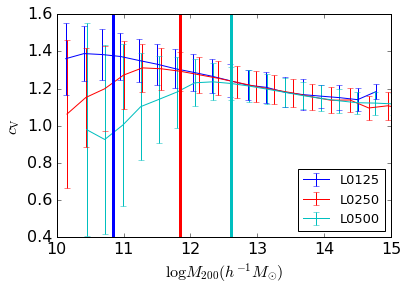

In [46]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 3

total_bins = 20

X1 = np.log10(hosts_data_l0125['halo_mass'])
Y1 = hosts_data_l0125['halo_cV']
X2 = np.log10(hosts_data_l0250['halo_mass'])
Y2 = hosts_data_l0250['halo_cV']
X3 = np.log10(hosts_data_l0500['halo_mass'])
Y3 = hosts_data_l0500['halo_cV']


bins = np.linspace(X1.min(),X1.max(), total_bins)
delta = bins[1]-bins[0]
idx  = np.digitize(X1,bins)
running_median = [np.median(Y1[idx==k]) for k in range(total_bins)]

running_std    = [Y1[idx==k].std() for k in range(total_bins)]
plt.errorbar(bins-delta/2,running_median,
              running_std, color='b', label='L0125', lw=1)

bins = np.linspace(X2.min(),X2.max(), total_bins)
delta = bins[1]-bins[0]
idx  = np.digitize(X2,bins)
running_median = [np.median(Y2[idx==k]) for k in range(total_bins)]

running_std    = [Y2[idx==k].std() for k in range(total_bins)]
plt.errorbar(bins-delta/2,running_median,
              running_std, color='r', label='L0250', lw=1)

bins = np.linspace(X3.min(),X3.max(), total_bins)
delta = bins[1]-bins[0]
idx  = np.digitize(X3,bins)
running_median = [np.median(Y3[idx==k]) for k in range(total_bins)]

running_std    = [Y3[idx==k].std() for k in range(total_bins)]
plt.errorbar(bins-delta/2,running_median,
              running_std, color='c', label='L0500', lw=1)

plt.axvline(x=np.log10(7e10), color='b')
plt.axvline(x=np.log10(7e11), color='r')
plt.axvline(x=np.log10(4e12), color='c')

plt.xlim(np.log10(1e10), 15)
plt.xlabel(r'$\log M_{\mathrm{200}} (h^{-1}M_{\odot})$')
plt.ylabel(r'$c_{\mathrm{V}}$')
plt.legend(numpoints=1, loc='lower right', prop={'size':13})
plt.savefig('./FIGS/masscut_cV_d200.pdf')

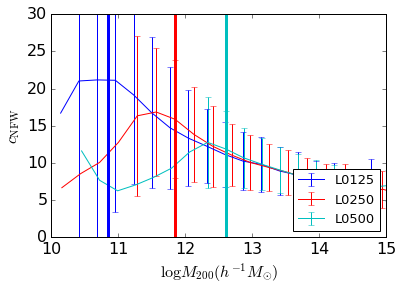

In [45]:
total_bins = 20

X1 = np.log10(hosts_data_l0125['halo_mass'])
Y1 = hosts_data_l0125['halo_cNFW']
X2 = np.log10(hosts_data_l0250['halo_mass'])
Y2 = hosts_data_l0250['halo_cNFW']
X3 = np.log10(hosts_data_l0500['halo_mass'])
Y3 = hosts_data_l0500['halo_cNFW']


bins = np.linspace(X1.min(),X1.max(), total_bins)
delta = bins[1]-bins[0]
idx  = np.digitize(X1,bins)
running_median = [np.median(Y1[idx==k]) for k in range(total_bins)]

running_std    = [Y1[idx==k].std() for k in range(total_bins)]
plt.errorbar(bins-delta/2,running_median,
              running_std, color='b', label='L0125', lw=1)

bins = np.linspace(X2.min(),X2.max(), total_bins)
delta = bins[1]-bins[0]
idx  = np.digitize(X2,bins)
running_median = [np.median(Y2[idx==k]) for k in range(total_bins)]

running_std    = [Y2[idx==k].std() for k in range(total_bins)]
plt.errorbar(bins-delta/2,running_median,
              running_std, color='r', label='L0250', lw=1)

bins = np.linspace(X3.min(),X3.max(), total_bins)
delta = bins[1]-bins[0]
idx  = np.digitize(X3,bins)
running_median = [np.median(Y3[idx==k]) for k in range(total_bins)]

running_std    = [Y3[idx==k].std() for k in range(total_bins)]
plt.errorbar(bins-delta/2,running_median,
              running_std, color='c', label='L0500', lw=1)

plt.axvline(x=np.log10(7e10), color='b')
plt.axvline(x=np.log10(7e11), color='r')
plt.axvline(x=np.log10(4e12), color='c')

plt.xlim(np.log10(1e10), 15)
plt.ylim(0,30)

plt.legend(numpoints=1, loc='lower right', prop={'size':13})
plt.xlabel(r'$\log M_{\mathrm{200}} (h^{-1}M_{\odot})$')
plt.ylabel(r'$c_{\mathrm{NFW}}$')
plt.savefig('./FIGS/masscut_cNFW_d200.pdf')

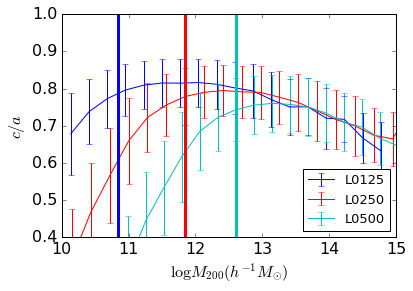

In [44]:
total_bins = 20

X1 = np.log10(hosts_data_l0125['halo_mass'])
Y1 = hosts_data_l0125['halo_ctoa']
X2 = np.log10(hosts_data_l0250['halo_mass'])
Y2 = hosts_data_l0250['halo_ctoa']
X3 = np.log10(hosts_data_l0500['halo_mass'])
Y3 = hosts_data_l0500['halo_ctoa']


bins = np.linspace(X1.min(),X1.max(), total_bins)
delta = bins[1]-bins[0]
idx  = np.digitize(X1,bins)
running_median = [np.median(Y1[idx==k]) for k in range(total_bins)]

running_std    = [Y1[idx==k].std() for k in range(total_bins)]
plt.errorbar(bins-delta/2,running_median,
              running_std, color='b', label='L0125', lw=1)

bins = np.linspace(X2.min(),X2.max(), total_bins)
delta = bins[1]-bins[0]
idx  = np.digitize(X2,bins)
running_median = [np.median(Y2[idx==k]) for k in range(total_bins)]

running_std    = [Y2[idx==k].std() for k in range(total_bins)]
plt.errorbar(bins-delta/2,running_median,
              running_std, color='r', label='L0250', lw=1)

bins = np.linspace(X3.min(),X3.max(), total_bins)
delta = bins[1]-bins[0]
idx  = np.digitize(X3,bins)
running_median = [np.median(Y3[idx==k]) for k in range(total_bins)]

running_std    = [Y3[idx==k].std() for k in range(total_bins)]
plt.errorbar(bins-delta/2,running_median,
              running_std, color='c', label='L0500', lw=1)

plt.axvline(x=np.log10(7e10), color='b')
plt.axvline(x=np.log10(7e11), color='r')
plt.axvline(x=np.log10(4e12), color='c')

plt.xlim(np.log10(1e10), 15)
plt.ylim(0.4,1)

plt.legend(numpoints=1, loc='lower right', prop={'size':13})
plt.xlabel(r'$\log M_{\mathrm{200}} (h^{-1}M_{\odot})$')
plt.ylabel(r'$c/a$')
plt.savefig('./FIGS/masscut_shape_d200.pdf')

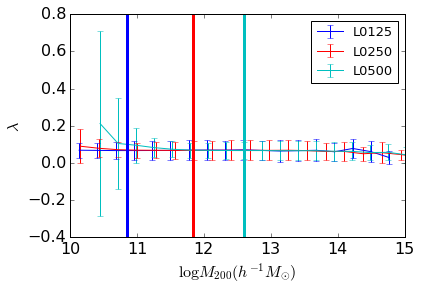

In [43]:
total_bins = 20

X1 = np.log10(hosts_data_l0125['halo_mass'])
Y1 = hosts_data_l0125['halo_spin']
X2 = np.log10(hosts_data_l0250['halo_mass'])
Y2 = hosts_data_l0250['halo_spin']
X3 = np.log10(hosts_data_l0500['halo_mass'])
Y3 = hosts_data_l0500['halo_spin']


bins = np.linspace(X1.min(),X1.max(), total_bins)
delta = bins[1]-bins[0]
idx  = np.digitize(X1,bins)
running_median = [np.median(Y1[idx==k]) for k in range(total_bins)]

running_std    = [Y1[idx==k].std() for k in range(total_bins)]
plt.errorbar(bins-delta/2,running_median,
              running_std, color='b', label='L0125', lw=1)

bins = np.linspace(X2.min(),X2.max(), total_bins)
delta = bins[1]-bins[0]
idx  = np.digitize(X2,bins)
running_median = [np.median(Y2[idx==k]) for k in range(total_bins)]

running_std    = [Y2[idx==k].std() for k in range(total_bins)]
plt.errorbar(bins-delta/2,running_median,
              running_std, color='r', label='L0250', lw=1)

bins = np.linspace(X3.min(),X3.max(), total_bins)
delta = bins[1]-bins[0]
idx  = np.digitize(X3,bins)
running_median = [np.median(Y3[idx==k]) for k in range(total_bins)]

running_std    = [Y3[idx==k].std() for k in range(total_bins)]
plt.errorbar(bins-delta/2,running_median,
              running_std, color='c', label='L0500', lw=1)

plt.axvline(x=np.log10(7e10), color='b')
plt.axvline(x=np.log10(7e11), color='r')
plt.axvline(x=np.log10(4e12), color='c')

plt.xlim(np.log10(1e10), 15)
plt.legend(numpoints=1, loc='upper right', prop={'size':13})
plt.xlabel(r'$\log M_{\mathrm{200}} (h^{-1}M_{\odot})$')
plt.ylabel(r'$\lambda$')
plt.savefig('./FIGS/masscut_spin_d200.pdf')